# 3.1 决策树的构造

## 3.1.1 信息增益

**程序清单3-1** 计算给定数据集的香农熵

In [1]:
from math import log

In [2]:
def calc_shannon_ent(data_set):
    num_entries = len(data_set)
    label_counts = {}
    for feat_vec in data_set:
        current_label = feat_vec[-1]
        if current_label not in label_counts.keys():
            label_counts[current_label] = 0
        label_counts[current_label] += 1
    shannon_ent = 0.0
    for key in label_counts:
        prob = float(label_counts[key])/num_entries
        shannon_ent -= prob * log(prob, 2)
    return shannon_ent

In [3]:
def create_data_set():
    data_set = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return data_set, labels

In [4]:
my_dat, labels = create_data_set()

In [5]:
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [6]:
calc_shannon_ent(my_dat)

0.9709505944546686

In [7]:
my_dat[0][-1] = 'maybe'

In [8]:
my_dat

[[1, 1, 'maybe'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [9]:
calc_shannon_ent(my_dat)

1.3709505944546687

## 3.1.2 划分数据集

**程序清单3-2** 按照给定特征划分数据集

In [10]:
def split_data_set(data_set, axis, value):
    ret_data_set = []
    for feat_vec in data_set:
        if feat_vec[axis] == value:
            reduced_feat_vec = feat_vec[:axis]
            reduced_feat_vec.extend(feat_vec[axis+1:])
            ret_data_set.append(reduced_feat_vec)
    return ret_data_set

In [11]:
a = [1, 2, 3]
b = [4, 5, 6]
a.append(b)
a

[1, 2, 3, [4, 5, 6]]

In [12]:
a = [1, 2, 3]
a.extend(b)
a

[1, 2, 3, 4, 5, 6]

In [13]:
my_dat, labels = create_data_set()

In [14]:
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [15]:
split_data_set(my_dat, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [16]:
split_data_set(my_dat, 0, 0)

[[1, 'no'], [1, 'no']]

**程序清单3-3** 选择最好的数据集划分方式

In [17]:
def choose_best_feature_to_split(data_set):
    num_features = len(data_set[0]) - 1
    base_entropy = calc_shannon_ent(data_set)
    best_info_gain = 0.0
    best_feature = -1
    for i in range(num_features):
        feat_list = [example[i] for example in data_set]
        unique_vals = set(feat_list)
        new_entropy = 0.0
        for value in unique_vals:
            sub_data_set = split_data_set(data_set, i, value)
            prob = len(sub_data_set)/float(len(data_set))
            new_entropy += prob * calc_shannon_ent(sub_data_set)
        info_gain = base_entropy - new_entropy
        if (info_gain > best_info_gain):
            best_info_gain = info_gain
            best_feature = i
    return best_feature

In [18]:
my_dat, labels = create_data_set()

In [19]:
choose_best_feature_to_split(my_dat)

0

In [20]:
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

## 3.1.3 递归创建决策树

In [21]:
import operator

In [22]:
def majority_cnt(class_list):
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.items(),
                               key=operator.itemgetter(1),
                               reverse=True)
    return sorted_class_count[0][0]

**程序清单3-4** 创建树的函数代码

In [23]:
def create_tree(data_set, labels):
    class_list = [example[-1] for example in data_set]
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]
    if len(data_set[0]) == 1:
        return majority_cnt(class_list)
    best_feat = choose_best_feature_to_split(data_set)
    best_feat_label = labels[best_feat]
    my_tree = {best_feat_label: {}}
    del(labels[best_feat])
    feat_values = [example[best_feat] for example in data_set]
    unique_vals = set(feat_values)
    for value in unique_vals:
        sub_labels = labels[:]
        my_tree[best_feat_label][value] = create_tree(split_data_set\
                                                     (data_set,
                                                     best_feat,
                                                     value),
                                                     sub_labels)
    return my_tree

In [24]:
my_dat, labels = create_data_set()

In [25]:
my_tree = create_tree(my_dat, labels)

In [26]:
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [27]:
my_dat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

# 3.2 在Python中使用Matplotlib注解绘制树形图

## 3.2.1 Matplotlib注解

**程序清单3-5** 使用文本注解绘制树节点

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
decision_node = dict(boxstyle="sawtooth", fc="0.8")
leaf_node = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

In [30]:
def plot_node(node_txt, center_pt, parent_pt, node_type):
    create_plot.ax1.annotate(node_txt, xy=parent_pt,
                            xycoords='axes fraction',
                            xytext=center_pt,
                            textcoords='axes fraction',
                            va='center', ha='center',
                            bbox=node_type,
                            arrowprops=arrow_args)
def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node('a decision node', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node('a leaf node', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()

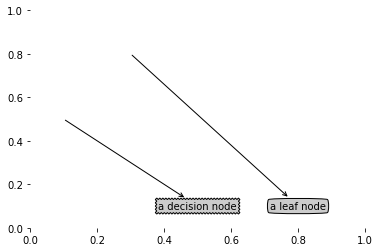

In [31]:
create_plot()

## 3.2.2 构造注解树

**程序清单3-6** 获取叶节点的数目和树的层数

In [32]:
def get_num_leafs(my_tree):
    num_leafs = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1
    return num_leafs

def get_tree_depth(my_tree):
    max_depth = 0
    first_str = list(my_tree.keys())[0]
    second_dict = my_tree[first_str]
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

In [33]:
def retrieve_tree(i):
    list_of_trees = [
        {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
        {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1:'no'}}}}
    ]
    return list_of_trees[i]

In [34]:
retrieve_tree(1)

{'no surfacing': {0: 'no',
  1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}

In [35]:
my_tree = retrieve_tree(0)

In [36]:
get_num_leafs(my_tree)

3

In [37]:
get_tree_depth(my_tree)

2

**程序清单3-7** `plot_tree`函数

In [38]:
def plot_mid_text(cntr_pt, parent_pt, txt_string):
    x_mid = (parent_pt[0]-cntr_pt[0])/2.0 + cntr_pt[0]
    y_mid = (parent_pt[1]-cntr_pt[1])/2.0 + cntr_pt[1]
    create_plot.ax1.text(x_mid, y_mid, txt_string)
    
def plot_tree(my_tree, parent_pt, node_txt):
    num_leafs = get_num_leafs(my_tree)
    depth = get_tree_depth(my_tree)
    first_str = list(my_tree.keys())[0]
    cntr_pt = (plot_tree.x_off + (1.0 + float(num_leafs))/2.0/plot_tree.total_w,
              plot_tree.y_off)
    plot_mid_text(cntr_pt, parent_pt, node_txt)
    plot_node(first_str, cntr_pt, parent_pt, decision_node)
    second_dict = my_tree[first_str]
    plot_tree.y_off = plot_tree.y_off - 1.0/plot_tree.total_d
    for key in second_dict.keys():
        if type(second_dict[key]).__name__=='dict':
            plot_tree(second_dict[key], cntr_pt, str(key))
        else:
            plot_tree.x_off = plot_tree.x_off + 1.0/plot_tree.total_w
            plot_node(second_dict[key], (plot_tree.x_off, plot_tree.y_off),
                     cntr_pt, leaf_node)
            plot_mid_text((plot_tree.x_off, plot_tree.y_off),
                         cntr_pt, str(key))
    plot_tree.y_off = plot_tree.y_off + 1.0/plot_tree.total_d
    
def create_plot(in_tree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plot_tree.total_w = float(get_num_leafs(in_tree))
    plot_tree.total_d = float(get_tree_depth(in_tree))
    plot_tree.x_off = -0.5/plot_tree.total_w
    plot_tree.y_off = 1.0
    plot_tree(in_tree, (0.5, 1.0), '')
    plt.show()

In [39]:
my_tree = retrieve_tree(0)

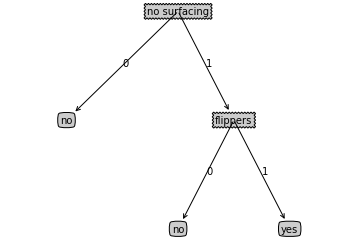

In [40]:
create_plot(my_tree)

In [41]:
my_tree['no surfacing'][3] = 'maybe'

In [42]:
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}, 3: 'maybe'}}

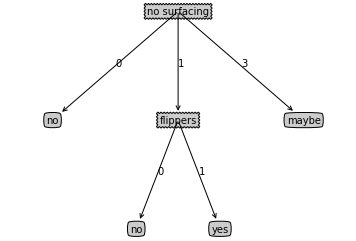

In [43]:
create_plot(my_tree)

# 3.3 测试和存储分类器

**程序清单3-8** 使用决策树的分类函数

In [50]:
def classify(input_tree, feat_labels, test_vec):
    first_str = list(input_tree.keys())[0]
    second_dict = input_tree[first_str]
    feat_index = feat_labels.index(first_str)
    for key in second_dict.keys():
        if test_vec[feat_index] == key:
            if type(second_dict[key]).__name__=='dict':
                class_label = classify(second_dict[key], feat_labels, test_vec)
            else:
                class_label = second_dict[key]
    return class_label

In [51]:
my_dat, labels = create_data_set()

In [52]:
labels

['no surfacing', 'flippers']

In [53]:
my_tree = retrieve_tree(0)

In [54]:
my_tree

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

In [55]:
classify(my_tree, labels, [1, 0])

'no'

In [56]:
classify(my_tree, labels, [1, 1])

'yes'

## 3.3.2 使用算法：决策树的存储

**程序清单3-9** 使用pickle模块存储决策树

In [59]:
def store_tree(input_tree, filename):
    import pickle
    fw = open(filename, 'wb')
    pickle.dump(input_tree, fw)
    fw.close()

def grab_tree(filename):
    import pickle
    fr = open(filename, 'rb')
    return pickle.load(fr)

In [60]:
store_tree(my_tree, 'classifier_storage.txt')

In [61]:
grab_tree('classifier_storage.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

# 3.4 示例：使用决策树预测隐形眼镜类型

In [62]:
fr = open('lenses.txt')

In [63]:
lenses = [inst.strip().split('\t') for inst in fr.readlines()]

In [64]:
lenses_labels = ['age', 'prescript', 'astigmatic', 'tear_rate']

In [65]:
lenses_tree = create_tree(lenses, lenses_labels)

In [66]:
lenses_tree

{'tear_rate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

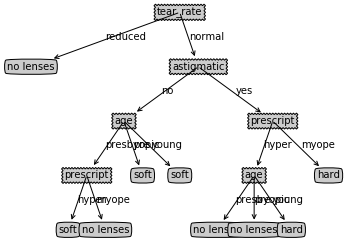

In [67]:
create_plot(lenses_tree)

In [68]:
store_tree(lenses_tree, 'lenses_tree.txt')

# 3.5 本章小结